# Decision Tree Classifier 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from math import log2
from sklearn import tree 
import graphviz 

## Goal 
- Predict the 'Type' of home using a decision tree. 
- The stopping condition is the depth of the tree. 
- The impurity measure is either entropy or gini. 

## Data Import 


In [2]:
df_train = pd.read_csv('https://gist.githubusercontent.com/yanyanzheng96/f8ba57f8377dee0810271475c728fca8/raw/afa3fa4305b55e31135980835d40b27af31f288c/melb_tree_train.csv')
df_test = pd.read_csv('https://gist.githubusercontent.com/yanyanzheng96/ec66da011b165f0e282c0c1f8447010e/raw/d02c3829a7e9db2d156ba1ab9d5bb4d18ae57be8/melb_tree_test.csv')
df_train.head(5)

,Rooms,Type,Price,Distance,Bedroom2,Bathroom,Car,Landsize,BuildingArea,YearBuilt,CouncilArea
0,2,t,771000.0,13.8,2.0,1.0,1.0,0.0,99.0,1992.0,Bayside
1,3,t,700000.0,7.9,3.0,2.0,1.0,189.0,110.0,1990.0,Banyule
2,3,u,975000.0,12.1,3.0,2.0,1.0,277.0,109.0,1975.0,Glen Eira
3,3,h,1290000.0,8.0,3.0,1.0,1.0,618.0,132.0,1960.0,Moonee Valley
4,2,u,500000.0,4.2,2.0,1.0,1.0,0.0,86.0,2000.0,Melbourne


In [3]:
df_X = df_train.drop('Type', axis=1) # everything but 'Type'
s_y = df_train['Type'] # just 'Type'

## Create function to calculate entropy 

In [4]:
def calc_entropy(s_y):
    counts = s_y.value_counts()
    entropy = 0
    for count in counts:
        pi = count/len(s_y)
        entropy -= pi * math.log2(pi)
    return entropy

In [5]:
# entropy of entire dataset 
trainEnt = calc_entropy(s_y)
trainEnt

1.582533311426178

In [6]:
# entropy of data with landsize less than or equal to 200
part1 = df_train[df_train['Landsize'] <= 200]
part1_s_y = part1['Type']
part1_ent = calc_entropy(part1_s_y)
part1_ent

1.3456432116206725

In [7]:
# entropy of data with landsize between 200 and 450
part2 = df_train[df_train['Landsize'] <= 450]
part2 = part2[part2['Landsize'] > 200]
part2_s_y = part2['Type']
part2_ent = calc_entropy(part2_s_y)
part2_ent

1.4660501816027975

In [8]:
# entropy of data with landsize greater than 450
part3 = df_train[df_train['Landsize'] > 450]
part3_s_y = part3['Type']
part3_ent = calc_entropy(part3_s_y)
part3_ent

1.09954792005911

## Create function to calculate the gini index 

In [9]:
def calc_gini( s_y ):
    counts = s_y.value_counts()
    gini = 1
    for count in counts:
        pi = count/len(s_y)
        gini -= pi**2
    return gini

In [10]:
# gini index of entire dataset 
trainGini = calc_gini(s_y)
trainGini

0.6655601280292637

In [11]:
# gini index of data with landsize less than or equal to 200
part1_gini = calc_gini(part1_s_y)
part1_gini

0.5741211482422965

In [12]:
# gini index of data with landsize between 200 and 450
part2_gini = calc_gini(part2_s_y)
part2_gini

0.6101021682602731

In [13]:
# gini index of data with landsize greater than 450 
part3_gini = calc_gini(part3_s_y)
part3_gini

0.4381934171597633

## Create a decision tree 
- Using scikit-learn to create a multi class classifer for the data set using the Entropy impurity measure and a max depth of 3.
- The algorithm can only handle categorical data, so that needs to be preprocessed using an one hot encoding.

In [14]:
# One Hot Encoding
encoded_y = pd.get_dummies(df_train['Type'], prefix='Type')
x = df_train.drop(columns=['Type'])
dummies = pd.get_dummies(df_train['CouncilArea'], prefix='CouncilArea')
removed = df_train.drop(columns=['CouncilArea', 'Type'])
encoded_x = pd.concat([dummies, removed], axis=1)

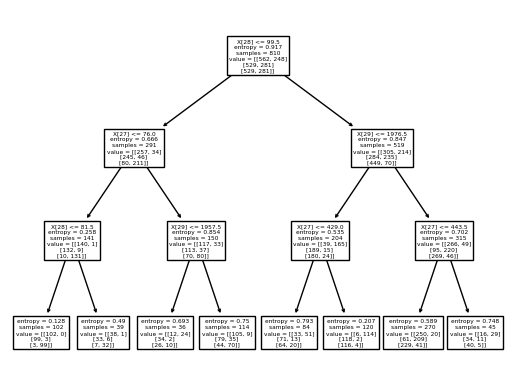

In [15]:
# Create Tree
clf = tree.DecisionTreeClassifier(criterion = 'entropy', max_depth = 3)
clf = clf.fit(encoded_x, encoded_y)
tree.plot_tree(clf);

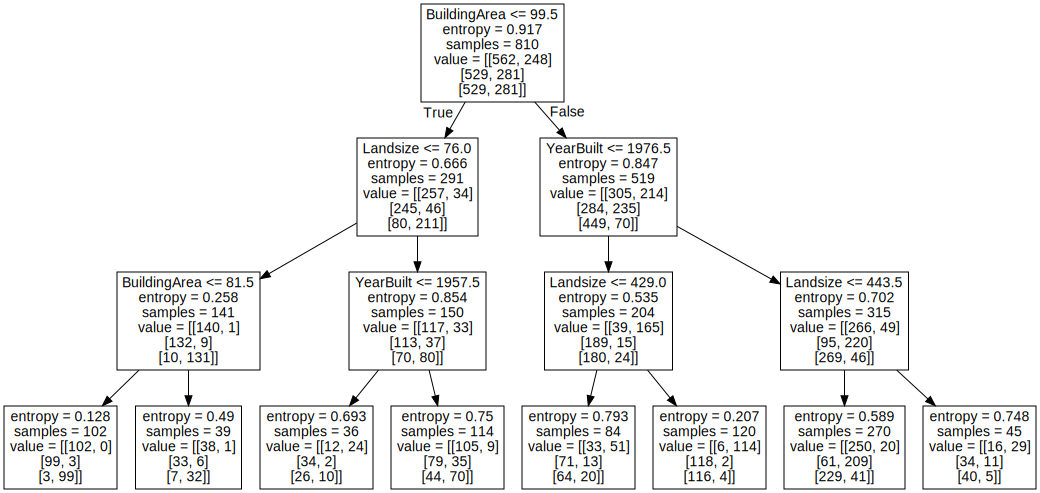

In [16]:
# Display graphviz version of the tree
dot_data = tree.export_graphviz(clf, out_file=None, feature_names = encoded_x.columns)
graph = graphviz.Source(dot_data)
graph.render("decision_tree")
graph

- The type of building is most correlated to the landsize, year built, and building area. These are the attributes on which the tree was built, using them as the splitting conditions for child nodes. 

## Calculate the Accuracy and Display Learning Curve
- Using the scikit-learn library to create many decision trees, each one with a different configuration (aka hyperparameters)
- Creating 28 different trees by:
   - Varying the max depth from 2 to 15 with the Gini Index as the impurity measure
   - Varying the max depth from 2 to 15 with the Entropy as the impurity measure
- For each of the 28 decistion trees, calculat the error rate by using the data in the training set and test set. 

In [17]:
# Load in the test data
encoded_y_test = pd.get_dummies(df_test['Type'], prefix='Type')
x = df_test.drop(columns=['Type'])
dummies = pd.get_dummies(df_test['CouncilArea'], prefix='CouncilArea')
removed = df_test.drop(columns=['CouncilArea', 'Type'])
encoded_x_test = pd.concat([dummies, removed], axis=1)

In [18]:
# Build the trees using the training data
treesG = []
treesE = []
for depth in range(2,16):
    clfG = tree.DecisionTreeClassifier(criterion = 'gini', max_depth = depth)
    clfG = clfG.fit(encoded_x, encoded_y)
    clfE = tree.DecisionTreeClassifier(criterion = 'entropy', max_depth = depth)
    clfE = clfE.fit(encoded_x, encoded_y)
    treesG += [clfG]
    treesE += [clfE]

trainErrorGs = []
trainErrorEs = []
testErrorGs = []
testErrorEs = []
for i in range(14):
    trainErrorG = 1 - treesG[i].score(encoded_x, encoded_y)
    trainErrorE = 1 - treesE[i].score(encoded_x, encoded_y)
    testErrorG = 1 - treesG[i].score(encoded_x_test, encoded_y_test)
    testErrorE = 1 - treesE[i].score(encoded_x_test, encoded_y_test)
    trainErrorGs += [trainErrorG]
    trainErrorEs += [trainErrorE]
    testErrorGs += [testErrorG]
    testErrorEs += [testErrorE]

depths = np.arange(2,16,1)

Text(0.5, 1.0, 'Error Rates of Trees with Different Depths and Impurity Measures')

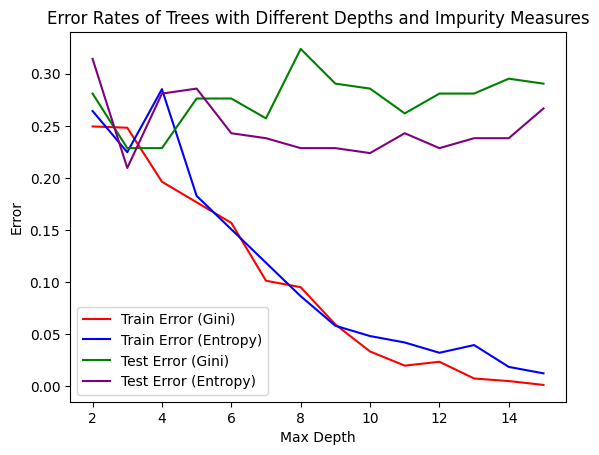

In [19]:
# Plot the 4 learning curves
plt.plot(depths, trainErrorGs, color='red', label='Train Error (Gini)')
plt.plot(depths, trainErrorEs, color='blue', label='Train Error (Entropy)')
plt.plot(depths, testErrorGs, color='green', label='Test Error (Gini)')
plt.plot(depths, testErrorEs, color='purple', label='Test Error (Entropy)')

plt.legend()
plt.xlabel('Max Depth')
plt.ylabel('Error')
plt.title('Error Rates of Trees with Different Depths and Impurity Measures')

## Conclusion 
- From this plot, it can be seen that the error rates of the training data (regardless of the impurity measure) have signifigantly lower error rates as compared to the testing data error rates as max depth increases. This trend makes sense because a tree trained on a certain dataset should work better on that specific dataset then it would on a new dataset on which it was not trained. 
- Looking at the difference between the test data errors for the gini and entropy measures, it can be seen that the trees using entropy as the impurity measure have lower errors rates than trees using gini. 